<a href="https://colab.research.google.com/github/ksnugroho/teori-praktik-cv-part1/blob/main/Bagian_3_Bab_9_9_2_Mask_R_CNN_untuk_Segmentasi_Instance_(Multiple_Classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch_snippets --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.3 MB/s eta 0:00:00


In [ ]:
!wget -q https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py

In [ ]:
!pip install -q -U 'git+https://github.com/sizhky/cocoapi.git@patch-1#subdirectory=PythonAPI'

  Preparing metadata (setup.py) ... done


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch_snippets import *

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!wget -q http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget -q http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar

In [ ]:
!dir

annotations_instance	  coco_eval.py	 engine.py  images.tar	 sample_data	utils.py
annotations_instance.tar  coco_utils.py  images     __pycache__  transforms.py


In [ ]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

In [ ]:
classes_list = [4,6]
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if np.array([num in np.unique(r) for num in classes_list]).sum()==0: continue
    annots.append(ann)

_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

100%|██████████| 20210/20210 [02:46<00:00, 121.65it/s]


In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
def get_mask(path):
    an = read(path, 1).transpose(2,0,1)
    r,g,b = an
    cls = list(set(np.unique(r)).intersection({4,6}))
    print(cls)
    masks = []
    labels = []
    for _cls in cls:
      nzs = np.nonzero(r==_cls)
      instances = np.unique(g[nzs])
      for ix,_id in enumerate(instances):
          masks.append(g==_id)
          labels.append(classes_list.index(_cls)+1)
    return np.array(masks), np.array(labels)

In [ ]:
_id = trn_items[10]
img_path = f'images/training/{_id}.jpg'

In [ ]:
get_mask(img_path)

[4, 6]


(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

In [ ]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N

    def get_mask(self,path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        cls = list(set(np.unique(r)).intersection({4,6}))
        masks = []
        labels = []
        for _cls in cls:
          nzs = np.nonzero(r==_cls)
          instances = np.unique(g[nzs])
          for ix,_id in enumerate(instances):
              masks.append(g==_id)
              labels.append(classes_list.index(_cls)+1)
        return np.array(masks), np.array(labels)

    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks, labels = self.get_mask(mask_path)
        #print(labels)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = ix
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8):
          img = img/255.
        return img, target
    def __len__(self):
        return self.N

    def choose(self):
        return self[randint(len(self))]

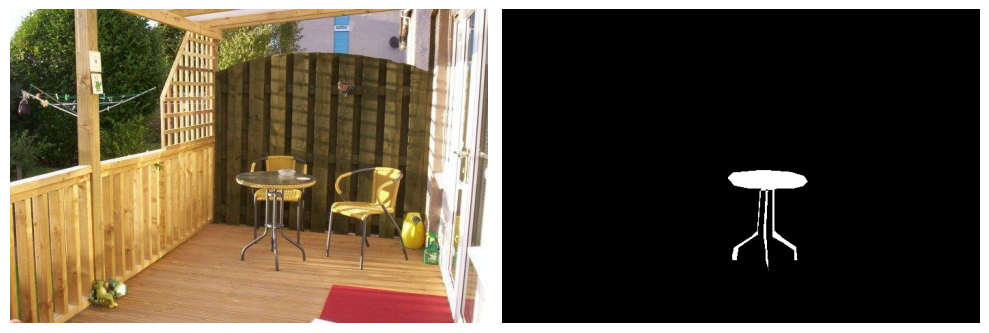

In [ ]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[1]
subplots([im, *targ['masks']], sz=10)

In [ ]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer,num_classes)
    return model

In [ ]:
model = get_model_instance_segmentation(3).to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 164MB/s]


In [ ]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [ ]:
num_classes = 3
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model.eval()
pred = model(dataset[0][0][None].to(device))

In [ ]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    lr_scheduler.step()
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1500]  eta: 0:30:10  lr: 0.000010  loss: 2.6343 (2.6343)  loss_classifier: 0.7491 (0.7491)  loss_box_reg: 0.0740 (0.0740)  loss_mask: 1.8003 (1.8003)  loss_objectness: 0.0097 (0.0097)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 1.2073  data: 0.0261  max mem: 2994
Epoch: [0]  [  10/1500]  eta: 0:16:12  lr: 0.000060  loss: 2.7726 (2.8322)  loss_classifier: 0.7684 (0.7664)  loss_box_reg: 0.3306 (0.3762)  loss_mask: 1.5622 (1.6080)  loss_objectness: 0.0319 (0.0552)  loss_rpn_box_reg: 0.0116 (0.0263)  time: 0.6529  data: 0.0459  max mem: 3846
Epoch: [0]  [  20/1500]  eta: 0:14:49  lr: 0.000110  loss: 2.3853 (2.5046)  loss_classifier: 0.6399 (0.6559)  loss_box_reg: 0.3025 (0.3499)  loss_mask: 1.2541 (1.4192)  loss_objectness: 0.0399 (0.0549)  loss_rpn_box_reg: 0.0115 (0.0248)  time: 0.5704  data: 0.0391  max mem: 4133
Epoch: [0]  [  30/1500]  eta: 0:14:31  lr: 0.000160  loss: 1.6834 (2.1256)  loss_classifier: 0.3594 (0.5448)  loss_box_reg: 0.2127 (0.3333)  loss_mask: 0.8980 (

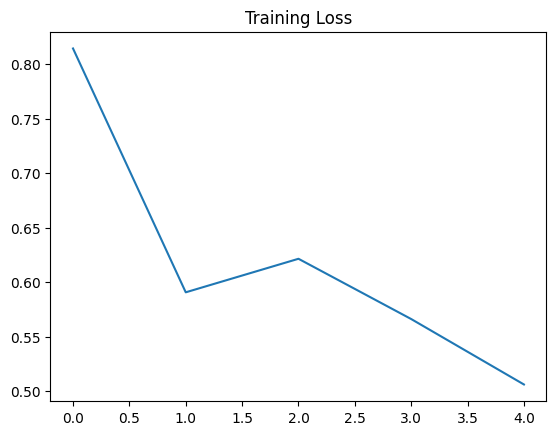

In [ ]:
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

In [ ]:
k=200

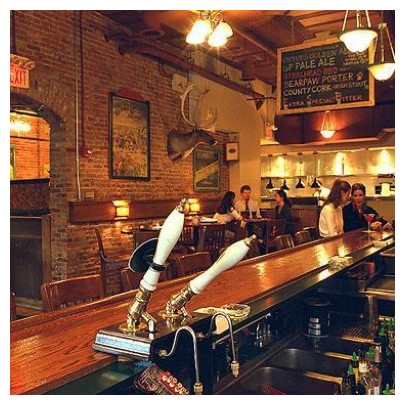

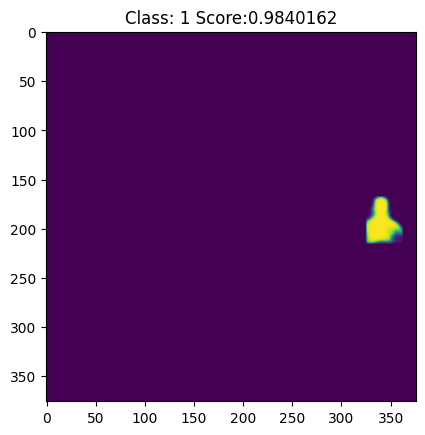

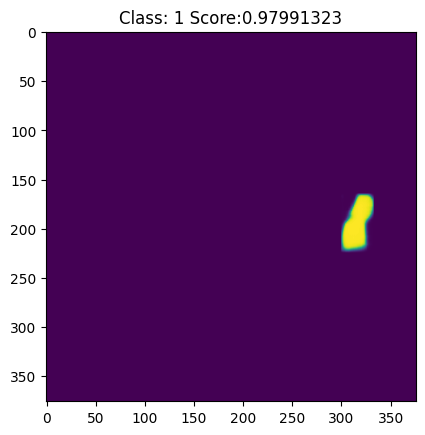

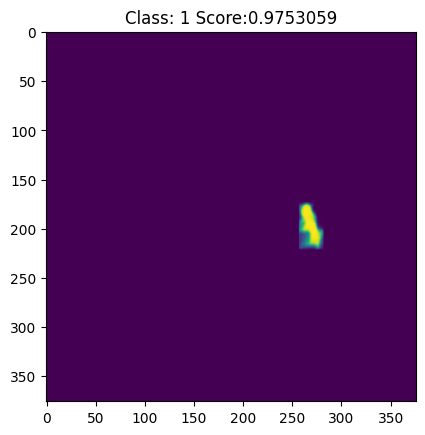

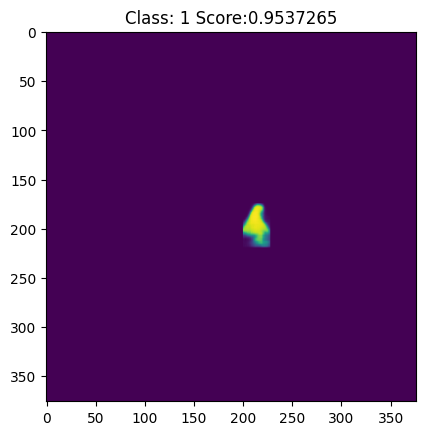

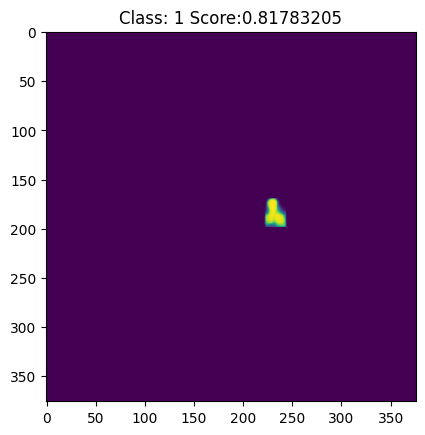

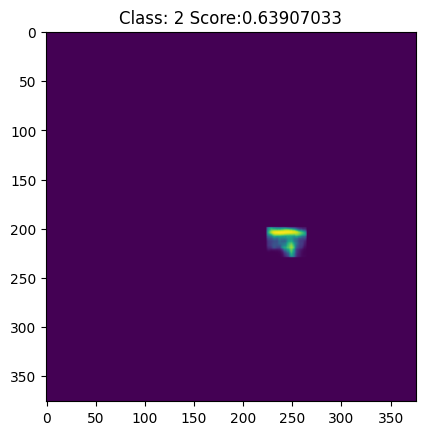

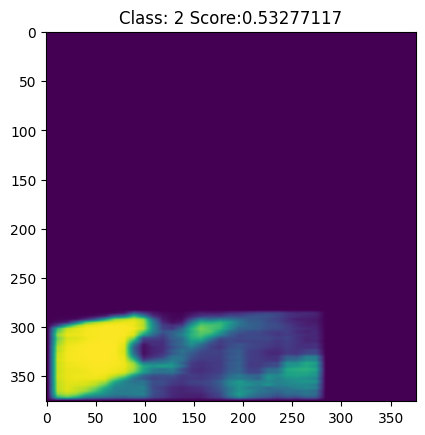

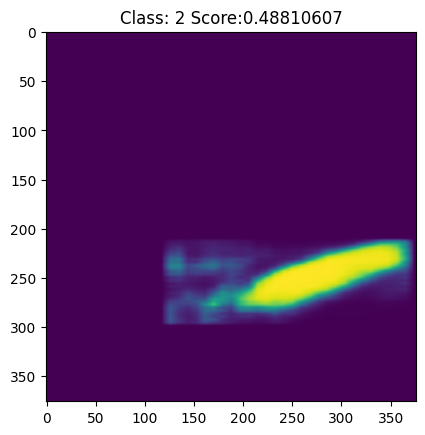

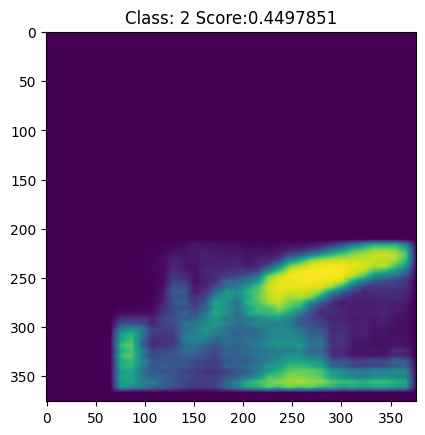

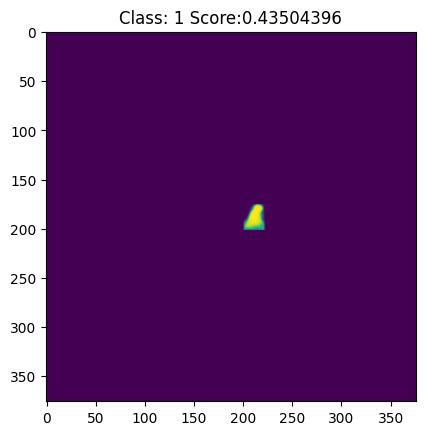

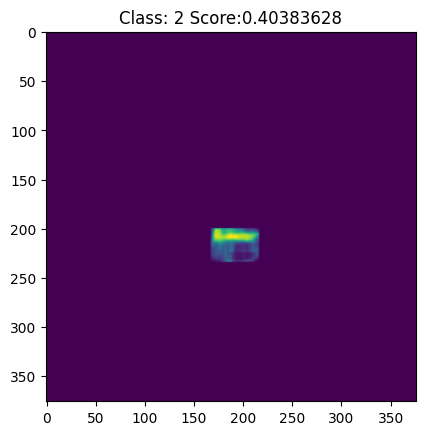

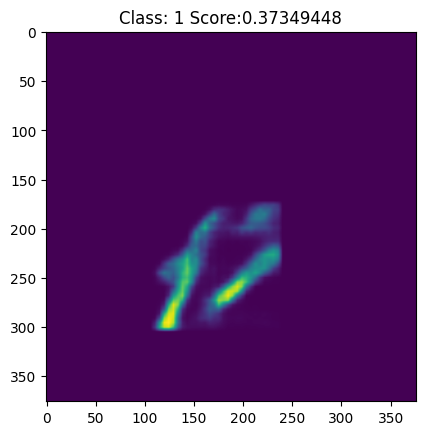

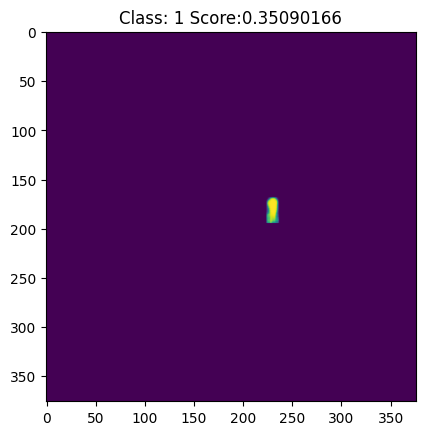

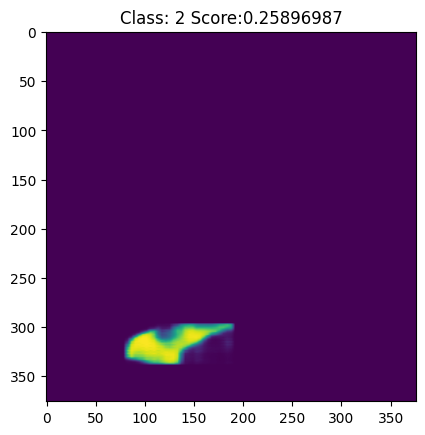

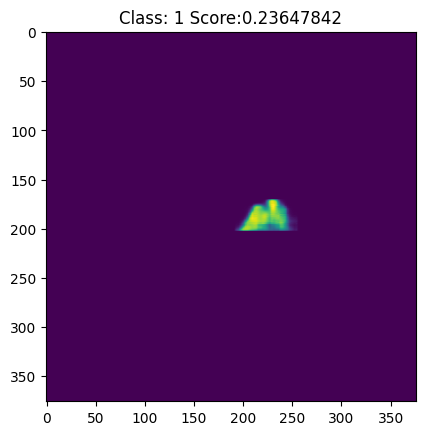

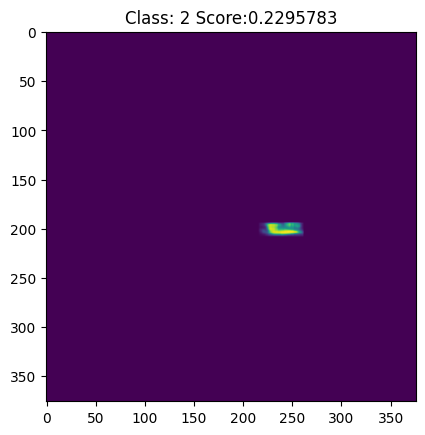

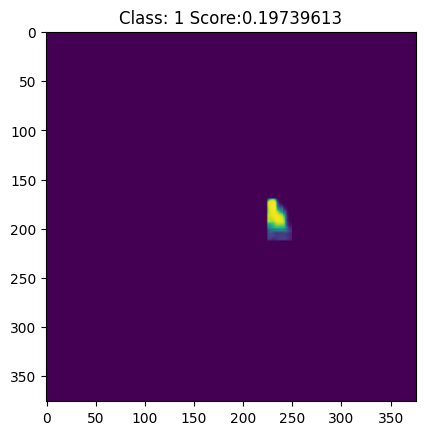

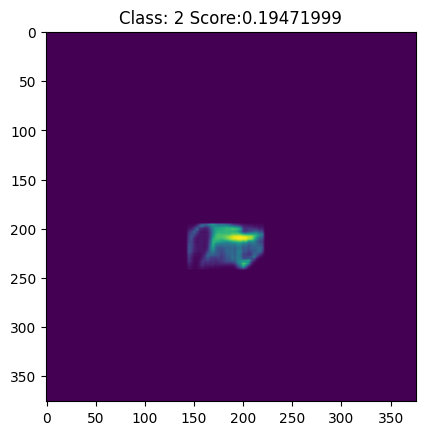

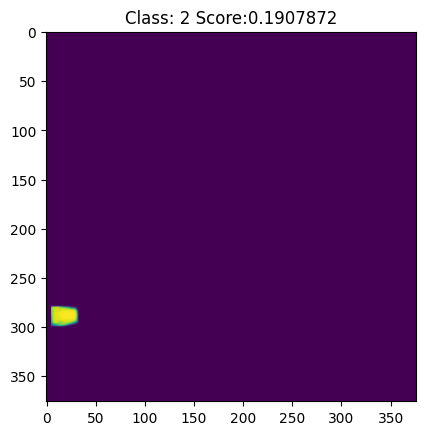

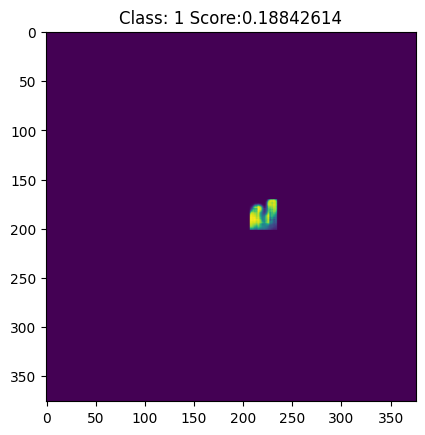

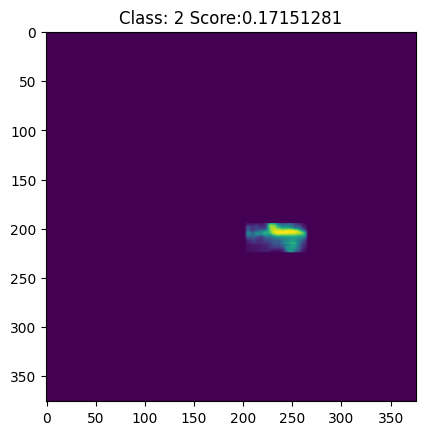

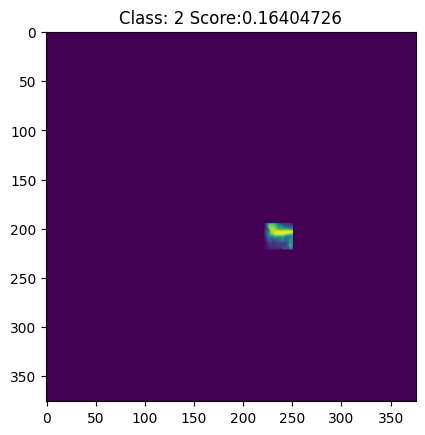

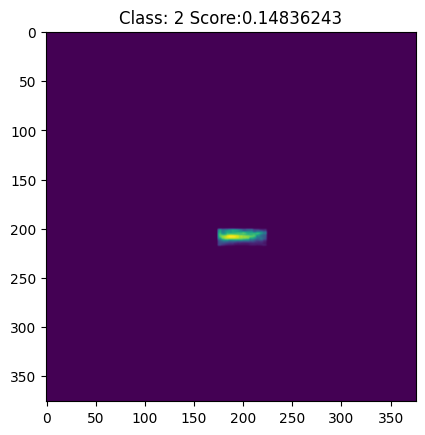

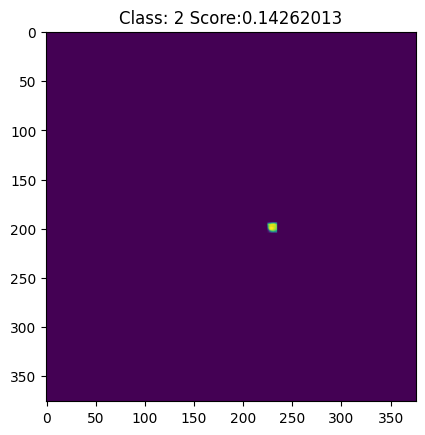

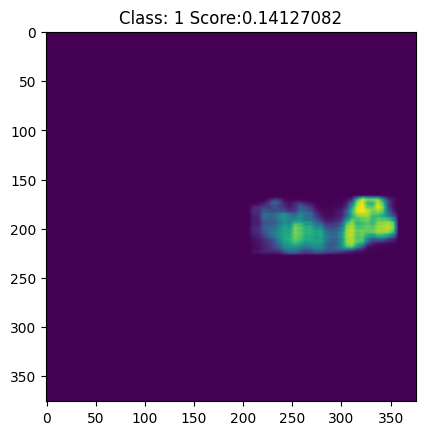

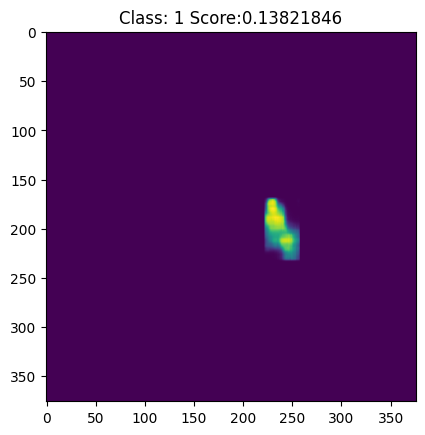

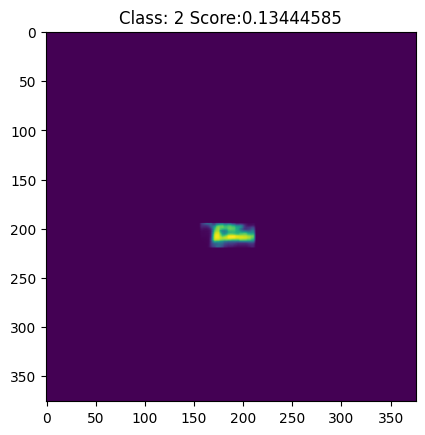

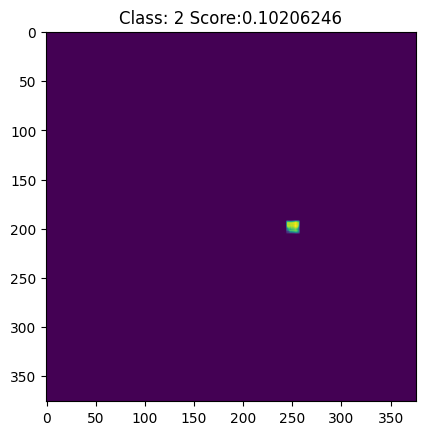

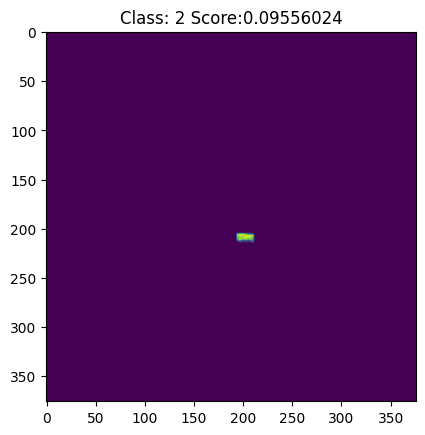

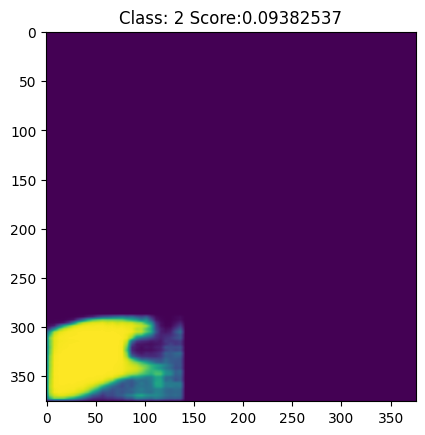

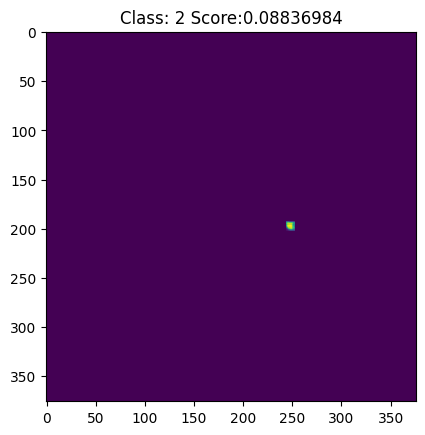

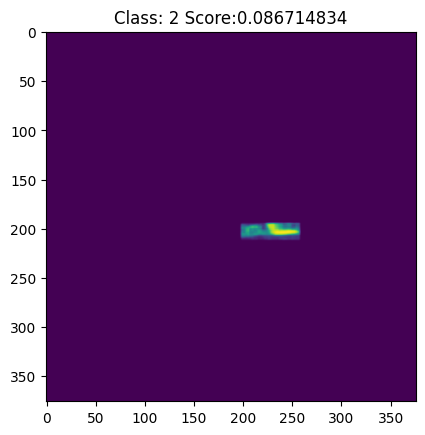

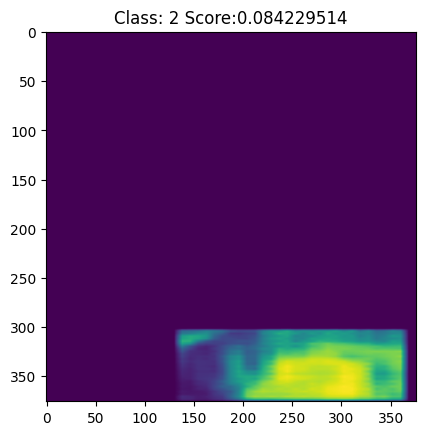

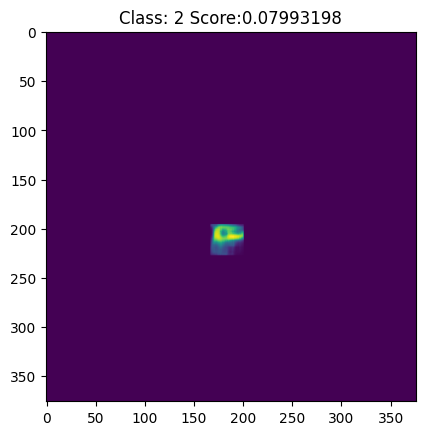

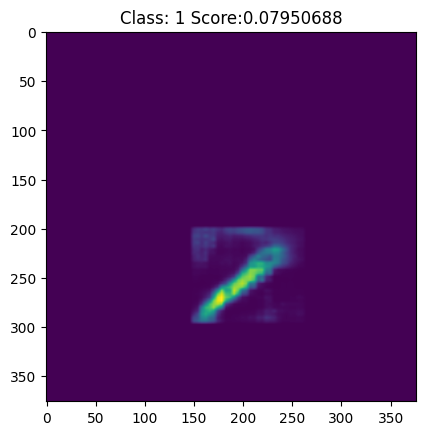

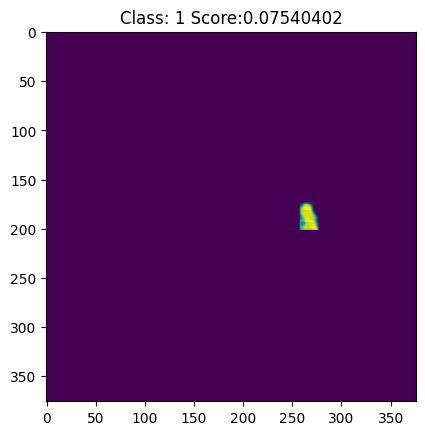

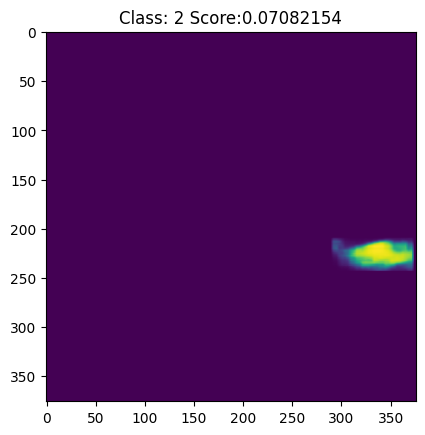

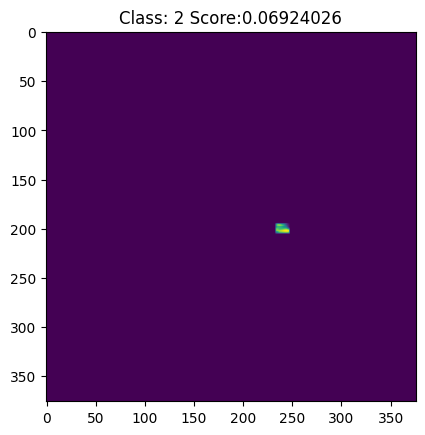

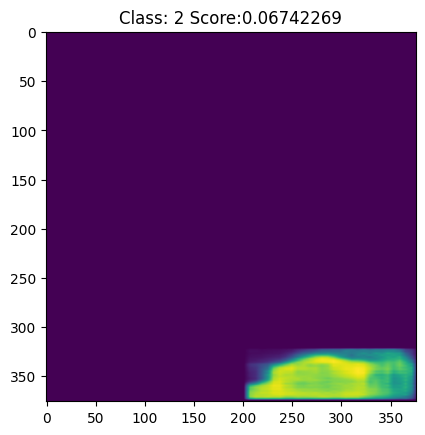

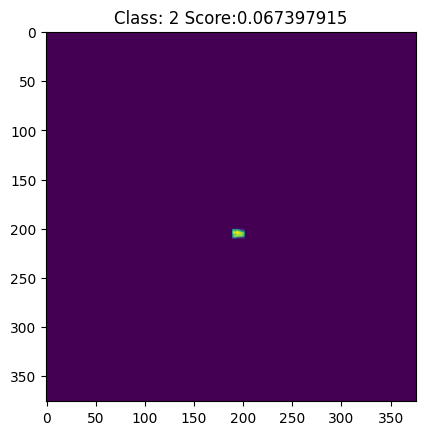

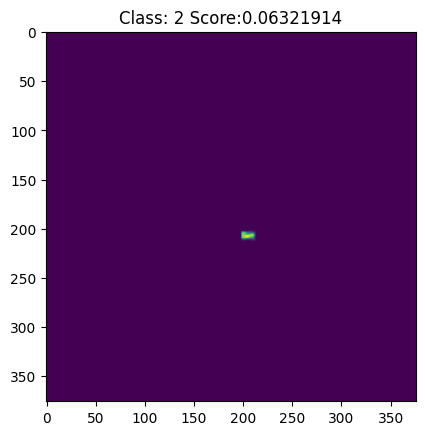

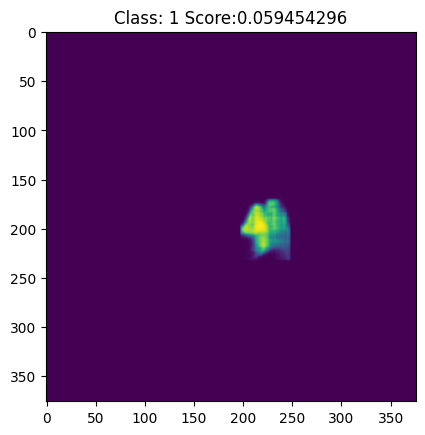

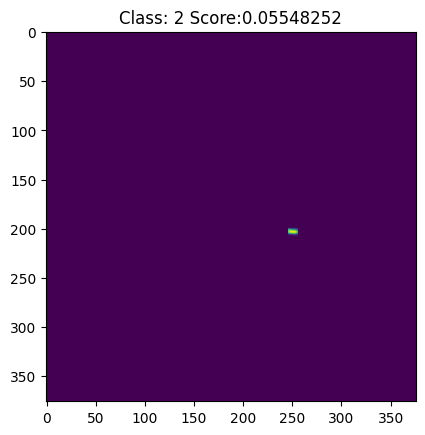

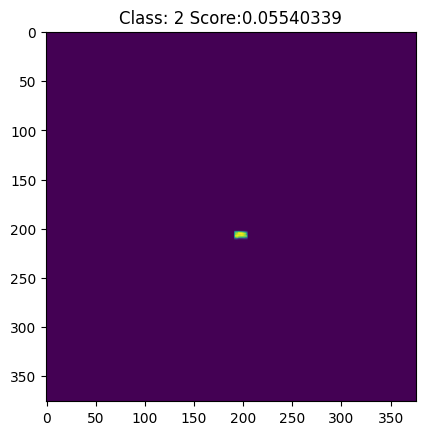

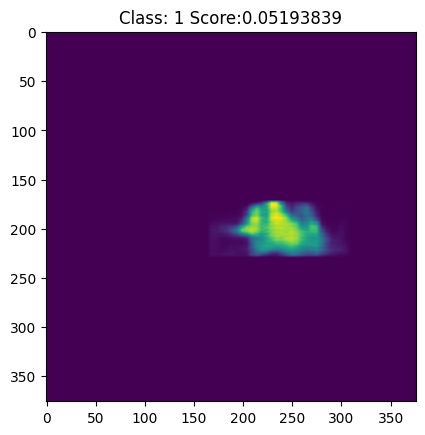

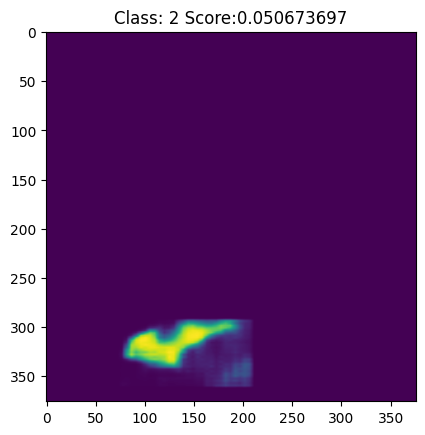

In [ ]:
model.eval()
k+=1
im = dataset_test[k][0]
show(im,sz=5)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()